# Template Fitting
## Zhuowen Zhang
### First Created April 16, 2018

In [2]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from code.halo_shape_calc import quad_moment
from code.lightcone_query_ra_dec import query_file, read_radial_bin
from code.setup.setup import data_home_dir
from code.setup.setup import code_home_dir
datadir = data_home_dir()
codedir = code_home_dir()


import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

## Import halo files

In [3]:
#Import halo files
halos_shape = np.load(datadir+'halos_shape_allz.npy')
#halos_shape = np.zeros(halos_num, dtype={'names':('halos_ID', 'richness', 'M200b', 'Rvir', 'redshift', 'axes_len', \
#       'axes_dir', 'halos_dir', 'converge'),'formats':('i', 'f', 'f','f','f','(3,)f','(3,3)f','(3,)f','i')})

#Apply convergence cut
#print 'Positions not converge:', np.where(halos_shape['converge'] != 1)
conv_cut = np.where(halos_shape['converge']==True)
halos_shape = halos_shape[conv_cut]
halos_num = len(halos_shape)

#quantities to extract
halos_RA = halos_shape['halos_RA']; halos_DEC = halos_shape['halos_DEC']
halos_coord = np.array([halos_RA, halos_DEC]).T
axes_len = halos_shape['axes_len']
axes_dir = halos_shape['axes_dir']
q = axes_len[:,2]/axes_len[:,0]
s = axes_len[:,1]/axes_len[:,0]
richness = halos_shape['richness']
halos_M200b = halos_shape['M200b']
lmda_max = np.max(richness)

#Find angle
#Orientation PDF
halos_dir = halos_shape['halos_dir']
axes_dir = halos_shape['axes_dir']
major_dir = axes_dir[:,2,:]

#absolute value of cosine of axis between major axis and LOS
cos_i = np.zeros(halos_num) #cos(i) in lingo of Osato 2017
for i in range(halos_num):
    halos_dir_mag = np.linalg.norm(halos_dir[i])
    major_mag = np.linalg.norm(major_dir[i]);
    cos_i[i] = np.abs(np.dot(major_dir[i],halos_dir[i])/(halos_dir_mag * major_mag))
#convert cosine to angle in degrees
angle_los_halo = np.arccos(cos_i) #*180/np.pi

print "Number of halos is", len(halos_shape)

Number of halos is 23703


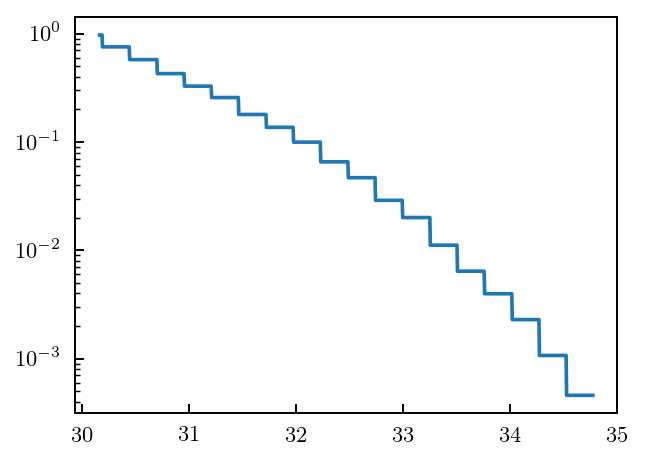

In [4]:
#Testing the halo mass function with Buzzard simulated data. 
from numpy import random as rnd
from code.halo_mass_template import P_lnM_Buzzard

fake_lnM = np.linspace(13.1*np.log(10), 15.1*np.log(10), 1000)
fake_P_lnM = P_lnM_Buzzard(fake_lnM, 20)
#print fake_P_lnM
plt.figure(figsize=(4,3))
plt.plot(fake_lnM, fake_P_lnM)
plt.yscale('log')
plt.show()

## Binning Halos Files -- by cos(i) and richness

In [17]:
##Cosine bins
#Bin by cos_i
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])

#Bin halos_shape by cosi bins
cosi_bins_ind = []
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    cosi_pos = np.where((cos_i >= cosi_bin_min) & (cos_i < cosi_bin_max))
    cosi_bins_ind.append(cosi_pos)  
    
#Richness bins
richness = halos_shape['richness']
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Bin halos_shape by richness bins
lmda_bins_ind = []
for i, lmda_bin in enumerate(lmda_bins):
    #print i, lmda_bin
    lmda_bin_min = lmda_bin[0]; lmda_bin_max = lmda_bin[1]
    lmda_pos = np.where((richness >= lmda_bin_min) & (richness < lmda_bin_max))
    lmda_bins_ind.append(lmda_pos)

Maximum richness after cuts is  303.044


## Template for richness-mass

In [5]:
import numpy as np
from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer
from code.halo_mass_template import P_lnM_Buzzard
from scipy.integrate import quad
from scipy.integrate import romberg

def make_model(lnls, lnms):
    A=Uniform('A', lower=0.1, upper=100 )
    B=Uniform('B', lower=0.0001, upper=10 )
    sig0=Uniform('sigma0', lower=0.001, upper=10.0 )   
    
    #Use table to approximate integration. Speed things up
    def norm_20_tab(A,B,sig0, lnM_min, lnM_max):       
        lnM_tab = np.linspace(lnM_min, lnM_max, 100); delta_lnM = lnM_tab[1]-lnM_tab[0]
        mu_lnl=np.log(A)+B*(lnM_tab-14.0*np.log(10.0)) #Changed May 1 2018 from mu_lnl=np.log(A)+B*(lnM_tab-14.0*np.log(10.0))
        var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
        P_lnM_tab = P_lnM_Buzzard(lnM_tab)
        norm_20 = np.sum((0.5-0.5*erf((np.log(20) - mu_lnl)/np.sqrt(2.0*var_lnl)))*P_lnM_tab*delta_lnM)
        return norm_20

    @pymc.stochastic(observed=True, plot=False)
    def log_prob(value=0, A=A, B=B, sig0=sig0):
        lnM_min = 13*np.log(10); lnM_max = 15.1*np.log(10)
        mu_lnl=np.log(A)+B*(lnms-14.0*np.log(10.0)) #changed May 1, 2018
        var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))

        norm_20 = norm_20_tab(A,B,sig0, lnM_min, lnM_max)
        log_prs=-0.5*(lnls-mu_lnl)**2/var_lnl -0.5*np.log(var_lnl) - np.log(norm_20) 

        tot_logprob=np.sum(log_prs)
        return tot_logprob
    return locals()

#### Template for shifting A only


In [10]:
for i in range(5):
    print "test{}".format(i)

test0
test1
test2
test3
test4


In [25]:
'''
lnls, lnms should be in bins. They should be binned in same way and should have same number of bins. 
Outmost dimension should be number of bins, inner dimension the parameter values in bin. 

Think about how to make this have multiple bins for A
'''

def make_model2(lnls, lnms):
    #Extract number of bins
    assert len(lnls)==len(lnms), "Number of bins different for lnls and lnms"
    num_bins = len(lnls)
    
    #Vary A across bins but keep B, Sigma the same across bins
    A = [None]*num_bins
    for i in range(num_bins):
        A[i]=Uniform('A_{}'.format(i), lower=0.1, upper=100)
    B=Uniform('B', lower=0.0001, upper=10 )
    sig0=Uniform('sigma0', lower=0.001, upper=10.0 )   
    
    #Use table to approximate integration. Speed things up
    lnM_min = 13*np.log(10); lnM_max = 15.1*np.log(10)
    lnM_tab = np.linspace(lnM_min, lnM_max, 1000); delta_lnM = lnM_tab[1]-lnM_tab[0]
    
    def norm_20_tab(A_i,B,sig0):       
        mu_lnl=np.log(A_i)+B*(lnM_tab-14.0*np.log(10.0)) #Changed May 1 2018 from mu_lnl=np.log(A)+B*(lnM_tab-14.0*np.log(10.0))
        var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
        P_lnM_tab = P_lnM_Buzzard(lnM_tab)
        norm_20 = np.sum((0.5-0.5*erf((np.log(20) - mu_lnl)/np.sqrt(2.0*var_lnl)))*P_lnM_tab*delta_lnM)
        return norm_20

    @pymc.stochastic(observed=True, plot=False)
    def log_prob(value=0, A=A, B=B, sig0=sig0):      
        tot_logprob = 0
        for i in range(num_bins):
            mu_lnl=np.log(A[i])+B*(lnms[i]-14.0*np.log(10.0)) #changed May 1, 2018
            var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
            norm_20 = norm_20_tab(A[i],B,sig0)
            log_prs=-0.5*(lnls[i]-mu_lnl)**2/var_lnl -0.5*np.log(var_lnl) - np.log(norm_20) 
            tot_logprob += np.sum(log_prs)
            
        return tot_logprob
    
    return locals()

In [13]:
#Testing integration for norm20
from scipy.integrate import quad
from scipy.integrate import romberg
## Test out integration of (1-erf) with P(M). 
## Try out different integration schemes and see which ones works best.


def norm_20_int(lnms,A,B,sig0):
    mu_lnl=A+B*(lnms)
    var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
    return (0.5-0.5*erf((np.log(20) - mu_lnl)/np.sqrt(2.0*var_lnl)))*P_lnM_Buzzard(lnms)

def norm_20_tab(A,B,sig0, lnM_min, lnM_max):
    lnM_tab = np.linspace(lnM_min, lnM_max, 1000); delta_lnM = lnM_tab[1]-lnM_tab[0]
    mu_lnl=A+B*(lnM_tab)
    var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
    P_lnM_tab = P_lnM_Buzzard(lnM_tab)
    norm_20 = np.sum((0.5-0.5*erf((np.log(20) - mu_lnl)/np.sqrt(2.0*var_lnl)))*P_lnM_tab*delta_lnM)
    return norm_20
    
y_quad = quad(norm_20_int, 13*np.log(10), 15.1*np.log(10), args=(10,1,0.5))
#y_quadrature = quadrature(norm_20, 13*np.log(10), 15.1*np.log(10), args=(10,1,0.5))
y_romberg = romberg(norm_20_int, 13*np.log(10), 15.1*np.log(10), args=(10,1,0.5))
print "scipy quad yields", y_quad
#print "scipy quadrature yields", y_quadrature
print "scipy romberg yields", y_romberg

y_tab = norm_20_tab(10,1,0.5, 13*np.log(10), 15.1*np.log(10))
print "From table with 1000 points ", y_tab




scipy quad yields (1.0003672189042057, 0.008908443248374143)
scipy romberg yields [1.00111581]
From table with 1000 points  1.0025415388905832


/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.516017e-03
  AccuracyWarning)


## Fake data: mass sampled from P(M) distribution

In [14]:
from numpy import random as rnd

call_delta = lambda step,Nstep,Dim: rnd.uniform(-step,step,(2*Nstep,Dim)) #random trial steps
#
# a simple single chain MCMC Metropolis sampler
#
def Metropolis_MCMC(modelpdf, x0, Nstep, nburn, step, xmin, xmax):
    nsample = 0; i = 0
    x = x0
    xchain = []
    xchain.append(x)
    
    delta = call_delta(step,Nstep,Dim)
    while nsample < Nstep:
        xtry = x + delta[i] # trial step
        
        #Set hard prior boundaries
        if (xtry < xmin) or (xtry > xmax):
            gxtry = -inf
        else:
            gxtry = np.log(modelpdf(xtry)) 
            gx = np.log(modelpdf(x))
        if gxtry > gx: 
            x = xtry; xchain.append(x)
            nsample += 1
        else:     
            aprob = gxtry - gx # acceptance probability
            u = rnd.uniform(0,1)
            if u < np.exp(aprob):
                x = xtry
                xchain.append(x)
            else:
                xchain.append(x)
            nsample += 1
        i += 1

    xnew = xchain[nburn:]
    xnew = np.array(xnew)
    return xnew


Dim = 1
n = 100000; nburn=50; step = 1
x0 = 14*np.log(10)
xchain = Metropolis_MCMC(P_lnM_Buzzard, x0, n, nburn, step, xmin=13*np.log(10), xmax=15.1*np.log(10))


/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


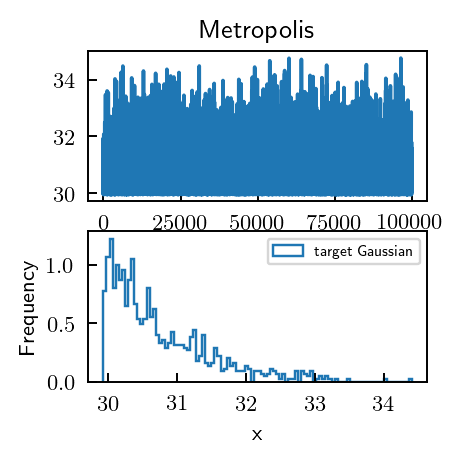

In [15]:
plt.figure(figsize=(2.5,2.5))
plt.subplot(211)
plt.title('Metropolis')
plt.plot(xchain)

plt.subplot(212)
plt.hist(xchain[::100,0], bins=100, histtype='step', normed=1)
#plt.plot(x, y, linewidth=.5, color='r')
plt.ylabel('Frequency')
plt.xlabel('x')
plt.legend(('target Gaussian','MCMC samples'), fontsize=6, loc='best', frameon='False')
plt.show()

### Test code with fake data.


#### Generating fake data. No bins

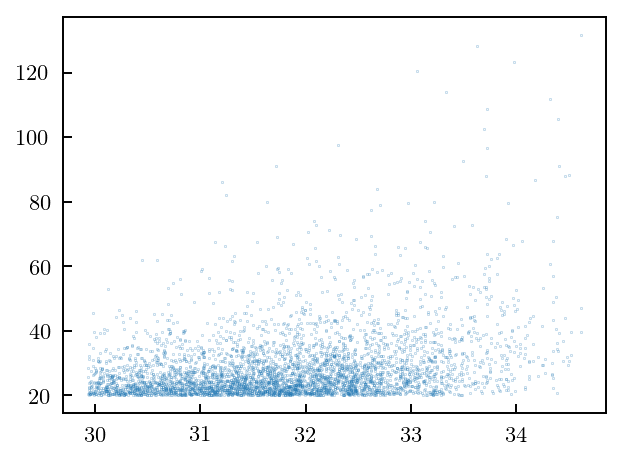

In [100]:
#Fake Data
#Let lnM sample from P_lnM_Buzzard
lnM = xchain[:,0] #1000 data points 
A=2.5; B=0.5;sig0=0.5
mu_lnl=A+B*(lnM-14.0*np.log(10.0))
var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
lnl=randn(len(lnM))*np.sqrt(var_lnl)+mu_lnl
# apply a lambda cut
ind=np.where(lnl >  np.log(20))
lnl_cut_fake=lnl[ind]
lnM_cut_fake=lnM[ind]

plt.figure(figsize=(4,3))
plt.plot(lnM_cut_fake, np.exp(lnl_cut_fake), marker='o', markersize='0.1', linestyle='None')
#plt.yscale('log')
plt.show()

#### Generating fake data binned by cos(i)

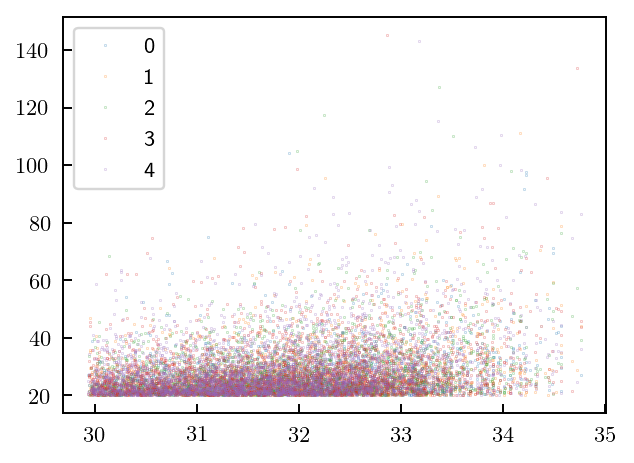

In [23]:
#Fake Data
#Let lnM sample from P_lnM_Buzzard
lnM = xchain[:,0] #1000 data points 
num_bins = len(cosi_bins)
A = [2.1, 2.2, 2.3, 2.4, 2.5]
B=0.5;sig0=0.5
lnl = [None] * num_bins


plt.figure(figsize=(4,3))

num_bins = len(cosi_bins)
lnl_cut_fake = [None]*num_bins
lnM_cut_fake = [None]*num_bins
#Think about how to produce fake data with bins.
for i, cosi_bin in enumerate(cosi_bins):
    mu_lnl=A[i]+B*(lnM-14.0*np.log(10.0))
    var_lnl=sig0**2+(np.exp(mu_lnl)-1)/(np.exp(2*mu_lnl))
    lnl=randn(len(lnM))*np.sqrt(var_lnl)+mu_lnl
    # apply a lambda cut
    ind=np.where(lnl > np.log(20))
    lnl_cut_fake[i]=lnl[ind]
    lnM_cut_fake[i]=lnM[ind]
    plt.plot(lnM_cut_fake[i], np.exp(lnl_cut_fake[i]), marker='o', markersize='0.1', linestyle='None', \
             label='{}'.format(i))
plt.legend()
plt.show()

In [28]:
#Run for all/fake data
mcmc_folder = datadir + 'p_lmda_fake_allz_varA'
#mcmc_folder = datadir + 'p_lmda_cosi_'+'all'
M=pymc.Model(make_model2(lnl_cut_fake, lnM_cut_fake))
#print make_model2(lnl_cut_fake, lnM_cut_fake)
mc=MCMC(M, db='txt', dbname=mcmc_folder)
num=200
n_iter=num*5000
n_burn=num*3000
n_thin=num
#mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

TypeError: hasattr(): attribute name must be string

In [86]:
#Plot fake data
mcmc_folder = datadir + 'p_lmda_fake_allz'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')
print np.mean(As), np.std(As)
print np.mean(Bs), np.std(Bs)
print np.mean(sig0s), np.std(sig0s)

# plot the parameter constraints
c = ChainConsumer()
data=np.vstack( (As, Bs, sig0s) ).T
c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
            name=r'Template for all data')
c.configure(colors=['k'], linestyles=[":"], shade=[True], shade_alpha=[0.5])   
c.analysis.get_summary()
#c.plotter.plot(display=True, figsize="column", truth=[10,1,0.5])
#plt.show()

-19.641752084083688 0.3119070713867843
0.6898943812863333 0.0093467341951174
0.4884441431649014 0.010080320615432948


{'$A$': [-19.92893765315243, -19.627195859233332, -19.299140490669476],
 '$B$': [0.6796433013399054, 0.6890345273147541, 0.6984257532896029],
 '$\\sigma_0$': [0.47828578491918516, 0.4883140161500244, 0.4988365532948914]}

## Plotting with real data, binned by cos(i)

In [117]:
#Using Real Data. Binned by cos_i
lnM200b = np.log(halos_M200b)
lnl = np.log(richness)

#Bin halos_shape by richness bins
cosi_bins = [[0.0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0]] #upper limit must match lower limit of next bin
mcmc_filestr = range(len(cosi_bins)) #refer to the cosine bins
cosi_bins_ind = []
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    cosi_pos = np.where((cos_i >= cosi_bin_min) & (cos_i < cosi_bin_max))
    cosi_bins_ind.append(cosi_pos)

num=200
n_iter=num*5000
n_burn=num*2000
n_thin=num    
    
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = datadir + 'p_lmda_cosi_allz_'+str(mcmc_filestr[i])
    cosi_bin_ind = cosi_bins_ind[i]
    M=pymc.Model(make_model(lnl[cosi_bin_ind], lnM200b[cosi_bin_ind]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)
    
#For all data
print '\n All data'
mcmc_folder = datadir + 'p_lmda_cosi_'+'allcosi_allz'
M=pymc.Model(make_model(lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)


 Bin number  0
 [-----------------100%-----------------] 1000000 of 1000000 complete in 767.1 sec
 Bin number  1
 [-----------------100%-----------------] 1000000 of 1000000 complete in 796.8 sec
 Bin number  2
 [-----------------100%-----------------] 1000000 of 1000000 complete in 805.6 sec
 Bin number  3
 [-----------------100%-----------------] 1000000 of 1000000 complete in 878.4 sec
 Bin number  4
 [-----------------100%-----------------] 1000000 of 1000000 complete in 1036.8 sec
 All data
 [-----------------100%-----------------] 1000000 of 1000000 complete in 2624.6 sec

In [119]:
from code.plot_utils import plot_2d_dist
from scipy.stats import sem

#For the 5 cosi_bins and combined data. Dictionary of data
chain_stat_list = [0 for x in range(len(cosi_bins)+1)]
    
for i in mcmc_filestr:
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    mcmc_folder = datadir + 'p_lmda_cosi_allz_'+str(mcmc_filestr[i])
        
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
    sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    # plot the parameter constraints
    c = ChainConsumer()
    data=np.vstack( (As, Bs, sig0s) ).T
    c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c.configure(statistics="max_shortest", colors=['k'], linestyles=[":"], shade=[True], shade_alpha=[0.5])
    #c.plotter.plot(filename="p_lmda_cosi_%i_chains.png"%i, figsize="column")
    #plt.show()
    chain_stat_list[i] = c.analysis.get_summary()
    
#For all data
mcmc_folder = datadir + 'p_lmda_cosi_'+'allcosi_allz'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')
#print np.mean(As), np.std(As)
#print np.mean(Bs), np.std(Bs)
#print np.mean(sig0s), np.std(sig0s)

# plot the parameter constraints
c = ChainConsumer()
data=np.vstack( (As, Bs, sig0s) ).T
c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
            name=r'Template for all data')
c.configure(statistics="max_shortest", colors=['k'], linestyles=[":"], shade=[True], shade_alpha=[0.5])    
chain_stat_list[-1] = c.analysis.get_summary()

#c.plotter.plot(filename="test1.png", figsize=(5,5))
#plt.show()
    
#If c.plotter.plot doesn't work manually use Andrey's plot_2d_hist to get your plots. 
#plot_2d_dist(As,Bs,xlim=[5,15],ylim=[0.8,1.2], clevs=[0.68,0.93,0.99],\
#             nxbins=50,nybins=50, cmin=1.e-4, cmax=1.0, xlabel='x',ylabel='y')



## Processing the posterior likelihood statistics

[[2.71115359 2.72622702 2.74942803]
 [2.75098552 2.76542494 2.78797876]
 [2.78770504 2.8058008  2.8215791 ]
 [2.83720276 2.85364002 2.86876648]
 [2.98989112 3.00314224 3.01523346]
 [2.82126801 2.82874193 2.83664684]]


Text(0.5,0,'$\\cos(i)$')

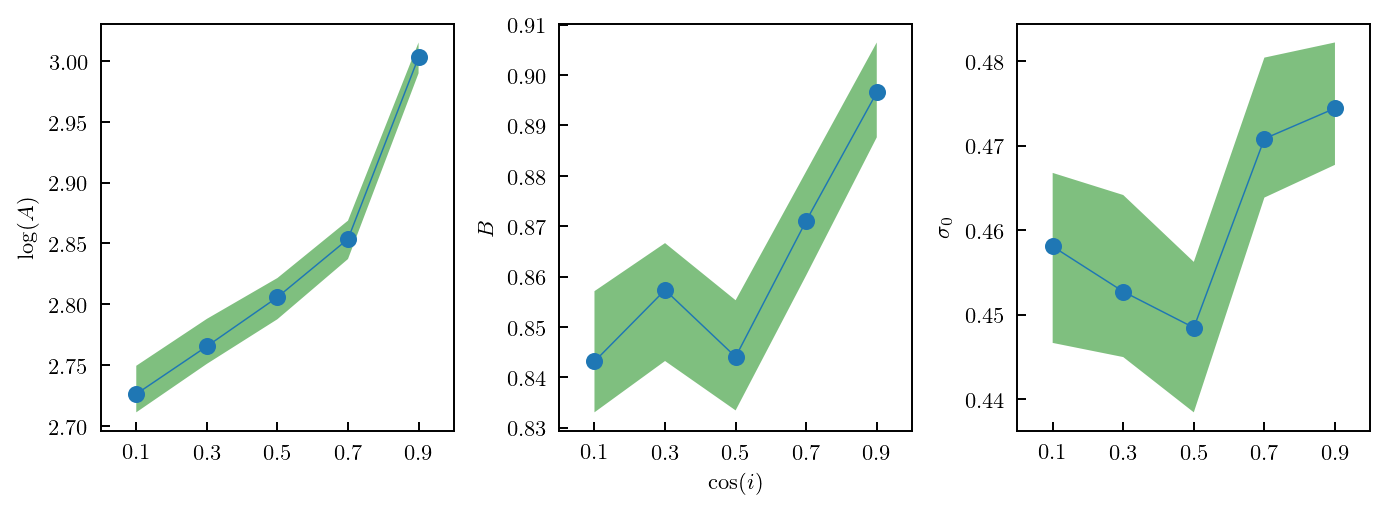

In [127]:
#Make evolution of parameters first
num_chain_bins = len(chain_stat_list)
num_stat = len(chain_stat_list[0])

lnA_cosi = np.zeros((num_chain_bins,3)); 
B_cosi = np.zeros((num_chain_bins,3)); 
sig0_cosi = np.zeros((num_chain_bins,3))
for i in range(num_chain_bins):
    lnA_cosi[i] = np.log(chain_stat_list[i]["$A$"])
    B_cosi[i] = chain_stat_list[i]["$B$"]
    sig0_cosi[i] = chain_stat_list[i]["$\sigma_0$"]
stat_cosi = [lnA_cosi, B_cosi, sig0_cosi]

#print stat_cosi[0][:,0]

#x parameters are the mean of each cosi_bin
x_pos = np.zeros(len(cosi_bins))
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    x_pos[i] = (cosi_bin_max+cosi_bin_min)/2.
#print x_pos
    
#print num_chain_bins, num_stat
fig, axs = plt.subplots(1 ,num_stat, tight_layout=True, figsize=(8,3))
subtitles = [r'$\log(A)$', r'$B$', r'$\sigma_0$']
stat_name = ["$A$", "$B$", "$\sigma_0$"]

#for the cosi binned data
for i in range(num_stat): 
    stat_lower = stat_cosi[i][0:-1,0]; stat_maxL = stat_cosi[i][0:-1,1]; stat_upper = stat_cosi[i][0:-1,2]
    axs[i].plot(x_pos, stat_maxL, linewidth=0.6, marker='o')
    axs[i].fill_between(x_pos, stat_lower, stat_upper, where=stat_upper >= stat_lower, 
                        facecolor='green', interpolate=True, alpha=0.5)
    axs[i].set_ylabel(subtitles[i])
    axs[i].set_xlim((0,1))
    axs[i].set_xticks(x_pos)
axs[1].set_xlabel(r'$\cos(i)$')
#axs[1].set_title('Evolution of richness-mass model parameter with orientation')
#plt.savefig('richness_mass_modelparams_cosibinned_043018')
#plt.show()
    
    


In [107]:
'''
# make another plot to show the fake data and the constraints
plt.loglog(np.exp(lnM_cut_fake),np.exp(lnl_cut_fake), 'k.');plt.xlabel(r'$M$');plt.ylabel(r'$\lambda$')
lnM=np.arange(31, 35, 0.1)
mu_lnl_arr=np.zeros([len(lnM), len(As)])
sig_lnl_arr=np.zeros([len(lnM), len(As)])
for ii in range(len(As)):
    A=As[ii];B=Bs[ii];sig0=sig0s[ii]
    mu_lnl_arr[:, ii]=np.log(A)+B*(lnM-14.0*np.log(10.0))
    sig_lnl_arr[:, ii]=np.sqrt(sig0**2+(np.exp(mu_lnl_arr[:, ii])-1)/(np.exp(2*mu_lnl_arr[:, ii])))
mu_lnl_mea=np.zeros([len(lnM)])
sig_lnl_mea=np.zeros([len(lnM)])
mu_lnl_std=np.zeros([len(lnM)])
sig_lnl_std=np.zeros([len(lnM)])
for jj in range(len(lnM)):
    mu_lnl_mea[jj]=np.mean(mu_lnl_arr[jj, :])
    mu_lnl_std[jj]=np.std(mu_lnl_arr[jj, :])
    sig_lnl_mea[jj]=np.mean(sig_lnl_arr[jj, :])
    sig_lnl_std[jj]=np.std(sig_lnl_arr[jj, :])
    
plt.plot(np.exp(lnM), np.exp(mu_lnl_mea), 'r')     
plt.fill_between(np.exp(lnM), np.exp(mu_lnl_mea-mu_lnl_std), np.exp(mu_lnl_mea+mu_lnl_std), facecolor='r', alpha=1)     
#plt.plot(np.exp(lnM), np.exp(mu_lnl_mea-sig_lnl_mea), 'r--')     
#plt.fill_between(np.exp(lnM), np.exp(mu_lnl_mea-sig_lnl_mea+sig_lnl_std), np.exp(mu_lnl_mea-sig_lnl_mea-sig_lnl_std), facecolor='r', alpha=1)     
#plt.plot(np.exp(lnM), np.exp(mu_lnl_mea+sig_lnl_mea), 'r--')    
#plt.fill_between(np.exp(lnM), np.exp(mu_lnl_mea+sig_lnl_mea+sig_lnl_std), np.exp(mu_lnl_mea+sig_lnl_mea-sig_lnl_std), facecolor='r', alpha=1)     
plt.show()
'''
print ""

To do: Make the data plots have colors according to different cosine bins

(15, 100)

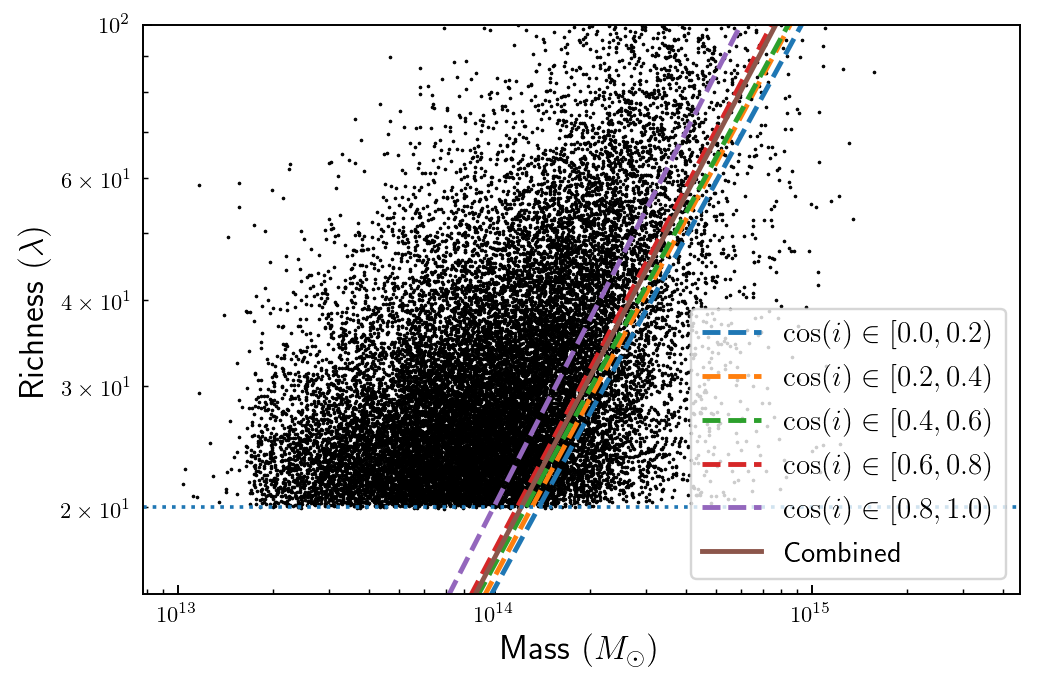

In [122]:
#Plot the trendlines for different bins
num_chain_bins = len(chain_stat_list)
num_stat = len(chain_stat_list[0])

A_cosi = np.zeros((num_chain_bins,3)); 
B_cosi = np.zeros((num_chain_bins,3)); 
sig0_cosi = np.zeros((num_chain_bins,3))
for i in range(num_chain_bins):
    A_cosi[i] = chain_stat_list[i]["$A$"]
    B_cosi[i] = chain_stat_list[i]["$B$"]
    sig0_cosi[i] = chain_stat_list[i]["$\sigma_0$"]
stat_cosi = [A_cosi, B_cosi, sig0_cosi]

fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(6,4))
axs.plot(halos_M200b, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    A_cosi_maxL = A_cosi[i,1]; B_cosi_maxL = B_cosi[i,1]; sig0_cosi_maxL = sig0_cosi[i,1];
    mu_lnl_model = np.log(A_cosi_maxL) + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
            label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max)
             

#for all data points    
A_cosi_maxL = A_cosi[-1,1]; B_cosi_maxL = B_cosi[-1,1]; sig0_cosi_maxL = sig0_cosi[-1,1];
mu_lnl_model = np.log(A_cosi_maxL) + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), \
            label='Combined', linewidth=2)
axs.axhline(20, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((15,100))
#plt.savefig('mass_richness_cosibinned_043018.png')
#plt.show()


## Template for amplitude shift only.